In [23]:
import argparse
from typing import Literal
from pathlib import Path

import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from PIL import Image
from PIL.ImageFile import ImageFile

from tqdm import tqdm
from torchvision import transforms as T

from dataloader import ImageDataset, TransformWrapper


In [10]:
sample_pth = Path('/Users/tsakalis/ntua/cellforge/data/the_perfect_candidate')

In [20]:
image_file_paths = sorted(list((sample_pth).glob('*.jpg')),
                          key=lambda x: int(x.stem.split('_')[0]))

In [41]:
image_size = 224

In [43]:
normalize_tensor = T.Compose([
    T.Lambda(lambda x: x.resize(
        (image_size, image_size), Image.Resampling.LANCZOS)),
    T.Lambda(lambda x: x.convert("RGB")),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Lambda(lambda x: x[:1, :]),
])

In [44]:
from torch.utils import data

In [108]:
dataloader = data.DataLoader(
    [normalize_tensor(Image.open(img)) for img in image_file_paths[-200:]],
    shuffle=False,
    batch_size=12)

In [46]:
inner_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)

whole_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
)

In [47]:
inner_model.load_state_dict(
    torch.load(
        '/Users/tsakalis/ntua/cellforge/cellforge/segmentation/model_weights/inner_embryo.pt'
    ))

whole_model.load_state_dict(
    torch.load(
        '/Users/tsakalis/ntua/cellforge/cellforge/segmentation/model_weights/full_embryo.pt'
    ))

/var/folders/gb/2dm73f1s22n8755ydqgrblxw0000gn/T/ipykernel_68069/934992615.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(
/var/folders/gb/2dm73f1s22n8755ydq

<All keys matched successfully>

In [50]:
device = 'mps'

inner_model.eval()
whole_model.eval()

inner_model.to(device)
whole_model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [78]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy()

In [82]:
from tqdm import tqdm

In [109]:
all_zps = []
for batch in tqdm(dataloader):

    mask_inner = torch.sigmoid(inner_model(batch.to(device)))
    mask_whole = torch.sigmoid(whole_model(batch.to(device)))

    zps = mask_whole - mask_inner

    all_zps.append(tensor_to_numpy(zps))


100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


In [92]:
import numpy as np

all_zps_ar = np.vstack(all_zps)

In [103]:
tensor_arr_normalized = ((all_zps_ar + 1) / 2) * 255
threshold = 128
binary_mask = (tensor_arr_normalized > threshold).astype(np.uint8) * 255

In [107]:
import numpy as np
import cv2

# Assume `tensor` is your NumPy array of shape (150, 1, 224, 224)
tensor_arr_normalized = ((all_zps_ar + 1) / 2) * 255
threshold = 128
binary_mask = (tensor_arr_normalized > threshold).astype(np.uint8) * 255
frames = np.squeeze(binary_mask, axis=1)

# Define the output video parameters
output_file = 'output_video.mp4'
frame_height, frame_width = frames.shape[1], frames.shape[2]
fps = 20  # Frames per second

# Define video codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 'mp4v' for .mp4
out = cv2.VideoWriter(output_file,
                      fourcc,
                      fps, (frame_width, frame_height),
                      isColor=False)

# Write each frame to the video
for frame in frames:
    out.write(frame)

# Release the VideoWriter
out.release()

print(f"Video saved as {output_file}")


Video saved as output_video.mp4


In [110]:
import numpy as np
from PIL import Image

# Assuming `tensor_arr` is your NumPy array with shape (150, 1, 224, 224) in range [-1, 1]

# Step 3: Remove the channel dimension to get (150, 224, 224)
frames = np.squeeze(binary_mask, axis=1)

# Step 4: Convert each frame to a Pillow Image and save as GIF
images = [Image.fromarray(frame, mode='L')
          for frame in frames]  # 'L' mode for grayscale
output_gif = 'output_animation.gif'
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],
    duration=100,  # Duration for each frame in milliseconds (adjust as needed)
    loop=0  # Loop forever (set to `1` for no looping)
)

print(f"GIF saved as {output_gif}")


GIF saved as output_animation.gif


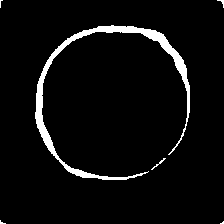

In [114]:
images[-10]